#Notebook
In this noteboook, use the exported tiff files to
-find min max (excl. <-30 dB values)
-calculate percentage of -30 dB pixels over images
-scale them
-remove/filter the -30 dB values
-write to tfrec
-for the ampslope representation




## Load libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
# import heapq, random
import pandas as pd

In [ ]:
from sklearn.utils import shuffle



In [ ]:
!pip install -q rasterio
import rasterio

In [ ]:
import tensorflow as tf

In [ ]:
import random


# Defintions

## Load (definitions)

### load files

In [ ]:
def subsplit(x):
  """"
  Returns the tile number of the tiff filename
  """"
  return x.split("_",1)[-1].split(".tif")[0]


def select_corresponding_files(files_x,files_y):
  """"
  Returns the x and y files in the same order,
  such that they correspond wrt tile number. 
  """"
  id_x = []
  for i in range(len(files_x)): #X becomes same as y, dif sequence than in X
    id_temp = subsplit(files_x[i])
    id_x.append(id_temp)

  id_y = [] #longer list possibly
  for i in range(len(files_y)): 
    id_temp = subsplit(files_y[i])
    id_y.append(id_temp)

  temp = set(id_x)
  res = [i for i, val in enumerate(id_y) if val in temp]

  files_y_corresponding = []
  for j in res: 
     files_y_corresponding.append(files_y[j])
  return  files_y_corresponding


In [ ]:

def get_files_ls(x_path, y_path):
  """"
  Return x and y (tiff) files/images
  Make sure that the files x and y containing landslides are corresponding 
  Do this for the files which contain landslides
  """

  files_y = [str(f) for f in pathlib.Path(y_path).glob('*.tif')] #binary
  files_x = [str(f) for f in pathlib.Path(x_path).glob('*.tif')] #prepost

  files_x = remove_duplicates_x(files_x)
  
  len_y = len(files_y)
  len_x = len(files_x)


  files_x.sort(key = lambda x: int(subsplit(x)))
  files_y.sort(key = lambda x: int(subsplit(x)))

  if (len_x != len_y):
    files_y = select_corresponding_files(files_x,files_y)

  return files_x,files_y



In [ ]:
def get_files_non_ls(x_path, y_path):
  """"
  Return x and y (tiff) files/images
  Do this for the files which do not contain landslides
  """
  files_y = [str(f) for f in pathlib.Path(y_path).glob('*.tif')] #binary
  files_x = [str(f) for f in pathlib.Path(x_path).glob('*.tif')] #prepost

  #Must copy one black image with the lenght of listX
  len_x = len(files_x)
  files_y_rpt = np.repeat(files_y,len_x) #not sure if necessary..
  
  return files_x,files_y_rpt

### open files

In [ ]:
def open_tiff_x(x):
  """"" Open tiff file x. The sar 1 and sar 2 band was accidentally wrongly turned with exporting
  so that is now redone here. The output are the three bands of the x tiff image
  """
  raster = rasterio.open(x)
  #accidentally the 1st band was sar2, second band sar1
  sar2 = raster.read(1) 
  sar1 = raster.read(2)
  dem = raster.read(3)
  return sar1,sar2,dem


In [ ]:

def open_tiff_y(y):
  """"
  Open tiff file y
  """"
  raster = rasterio.open(y)
  y = raster.read()
  # shape needs to be (256,256,1) (currently 1,256,256) Might depend per region what they have..
  y_moved = np.moveaxis(y, 0, -1) #np array, source  (axis), destination (axis)
  return y_moved


### divide into train , test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def split_train_test_val(x,y,test_size,val_size):
  """" Divide data into a train, val and test set 
  Train is for training model, val is for validating (and thus choosing) model during training,
  test is for testing the final model after training and thus qualifying the model
  For a division of 0.7,0.1,0.2 then use test size = 0.2, and then test_size = 0.125
  """
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=1)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=1) # 0.125 x 0.8 = 0.1
  return x_train, y_train,x_test,y_test,x_val,y_val

In [ ]:
def split_train_test(x,y,test_size):
  """" Divide data into a train, test set 
  Train is for training model,
  test is for testing the final model after training and thus qualifying the model
  """
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=1)
  return x_train, y_train,x_test,y_test

### Remove duplicates

In [ ]:

def remove_duplicates_x_list(files_x):
  """"
  Remove duplicate files
  """"
  x_list = files_x.tolist()
  for item in x_list:
    tile_nr = get_tile_nr(item)
    if ("(" in item):
      print(item)
      x_list.remove(item)
  return x_list

def remove_duplicates_list_xy(files_x,files_y):
  """"
  Remove duplicate files
  """"
  x_list = files_x.tolist()
  for item in x_list:
    tile_nr = get_tile_nr(item)
    if ("(" in item):
      # print(item)
      x_list.remove(item)
  return x_list,files_y[0:len(x_list)]



def remove_duplicates_x(files_x):
  for item in files_x:
    tile_nr = get_tile_nr(item)
    if ("(" in item):
      # print(item)
      files_x.remove(item)
  return files_x



## scale values def
THe values need to be scaled to [-1,1] for cgan model and [0,1] for U-Net

In [ ]:
#function to map from left (original) to right (scaled)
def scaleGrid(input_grid,leftMin,leftMax, rightMin,rightMax):
  '''
  objective: map the values of the input grid to the proposed range
  input_grid: grid with values
  leftMin,leftMax: min and max of the original input grid
  rightMin,rightMax: min and max of the range to which the data is mapped  
  '''
 
  leftSpan = leftMax - leftMin
  rightSpan= rightMax - rightMin
 
  valueScaled = (input_grid - leftMin) / float(leftSpan)
  valueScaled = np.round(rightMin + (valueScaled * rightSpan),4)

 
  return valueScaled

In [ ]:
def remove_nan(arr,fill):
  """"
  Returns array with nan values replaced by fill value
  arr: input numpy array
  fill: fill value
  """"
  arr[np.isnan(arr)] = fill
  return arr

In [ ]:
def scale_x(sar1,sar2,dem,max_sar,max_value = 0.8):
  """"
  Return the three bands of the ampslope image
  Scale the values
  min_sar is -29 since <-30 is filtered out
  """"

  #scale X
  min_sar = -29 
  # max_sar = 26 #differs per asc/des.
  min_dem = 0
  max_dem = 85

  #remove - 30 dB

  sar1 = scaleGrid(sar1,min_sar,max_sar,-1,max_value)
  sar2 = scaleGrid(sar2,min_sar,max_sar,-1,max_value)
  dem = scaleGrid(dem,min_dem,max_dem,-1,max_value)

  return sar1,sar2,dem

In [ ]:
def scale_y(y):
  """"
  Returns the y image with scaled values
  """"
  fill = -1
  scaledY = scaleGrid(y,0,255,-1,1)
  scaledY = remove_nan(scaledY,fill)
  return scaledY


In [ ]:
def remove_bad_pixels_before_scaling(sar1,sar2,dem):
  
  bad_pixel = -29.0
  fill = -29.0

  #Remove values below -30 dB as suggested by GEE. Would have been nicer if done during export but whateve
  id1 = np.argwhere(sar1 <= bad_pixel)
  for i in range(len(id1)):
    (sar1[id1[i][0],id1[i][1]]) = fill
  
  id2 = np.argwhere(sar2 <= bad_pixel)
  for i in range(len(id2)):
    (sar2[id2[i][0],id2[i][1]]) = fill

  id3 = np.argwhere(dem <= 0.0)
  for i in range(len(id3)):
    (dem[id3[i][0],id3[i][1]]) = 0.0

  #also do removeNan here
  sar1 = remove_nan(sar1,fill)
  sar2 = remove_nan(sar2,fill)
  dem = remove_nan(dem,fill)

  return sar1,sar2,dem

In [ ]:
# Remove -30 dB and lower  pixel values
#Save these sar bands to new npz
def remove_bad_pixels_after_scaling(sar1,sar2,dem):
  
  bad_pixel = -1
  fill = -1

  #Remove values below -30 dB as suggested by GEE. Would have been nicer if done during export but whateve
  id1 = np.argwhere(sar1 <= bad_pixel)
  for i in range(len(id1)):
    (sar1[id1[i][0],id1[i][1]]) = fill
  
  id2 = np.argwhere(sar2 <= bad_pixel)
  for i in range(len(id2)):
    (sar2[id2[i][0],id2[i][1]]) = fill

  id3 = np.argwhere(dem <= bad_pixel)
  for i in range(len(id3)):
    (dem[id3[i][0],id3[i][1]]) = fill

  #also do removeNan here
  sar1 = remove_nan(sar1,fill)
  sar2 = remove_nan(sar2,fill)
  dem = remove_nan(dem,fill)

  return sar1,sar2,dem

In [ ]:
def to_np_float(arr):
  arr = np.float32(arr)
  return arr

In [ ]:
def get_tile_nr(x):
  return x.split("_",1)[-1].split(".tif")[0] 

def remove_duplicates(files_x,files_y): #does this work well... Should be other way around to..
  for item in files_x:
    tile_nr = get_tile_nr(item)
    if ("(" in item):
      # print(item)
      files_x.remove(item)
  for item in files_y:
    tile_nr = get_tile_nr(item)
    if ("(" in item):
      files_y.remove(item)

  return files_x,files_y

## Open the npz files

In [ ]:
def remove_duplicates(files_x,files_y):
  for item in files_x:
    tile_nr = get_tile_nr(item)
    if ("(" in item):
      # print(item)
      files_x.remove(item)
  return files_x,files_y[0:len(files_x)]

import random

def merge(np_file_path):
  npfile = np.load(np_file_path)
  x1 = npfile['arr_0']
  y1 = npfile['arr_1']
  x2 = npfile['arr_2']
  y2 = npfile['arr_3'] 

  x = x1.tolist() + x2.tolist()
  y = y1.tolist() + y2.tolist()

  x,y =remove_duplicates(x,y)
  
  return x,y

def open_npz_ls(np_file_path):
  npfile = np.load(np_file_path)
  x1 = npfile['arr_2']
  y1 = npfile['arr_3'] 

  x = x1.tolist()
  y = y1.tolist()

  x,y = remove_duplicates(x,y)
  
  return x,y

def open_npz_non_ls(np_file_path):
  npfile = np.load(np_file_path)
  x1 = npfile['arr_0']
  y1 = npfile['arr_1']


  x = x1.tolist()
  y = y1.tolist()
  x,y = remove_duplicates(x,y)

  return x,y 

## Find/Sort on largest ls ratio 

In [ ]:
def find_non_zero(fn):
  """"" 
  Return the file and the corresponding id(s) of ls pixels
  Return the id(s) of ls pixels --> amount gives indication of amount ls pixels
  """""
  raster = rasterio.open(fn)
  f = raster.read()
  idy = np.argwhere(f > 0) 
  # return f,idy #or return the read file...?
  return idy

def sort_on_ls_ratio(files_x,files_y):
  """"" 
  Sort the files on their amount of ls pixels
  """""
  len_largest = []
  for i in range(len(files_y)):
    id_y = find_non_zero(files_y[i])
    amount_ls_pixels = len(id_y)
    len_largest.append(amount_ls_pixels)

  df = pd.DataFrame({"fn_x":files_x,"fn_y":files_y,"ls_amount":len_largest})
  #sort the df on len_largest aka amount of ls pixels
  df_sorted = df.sort_values(by="ls_amount",ascending=False)
  return df_sorted
  
  

In [ ]:
def get_ordered_ls_x_y(files_x,files_y):
  df = sort_on_ls_ratio(files_x,files_y)
  x = df.iloc[:,0].tolist()
  y = df.iloc[:,1].tolist()
  return x,y

## Convert to tfRecord

### Serialize example

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# def _int32_feature(value):
#   """Returns an int64_list from a bool / enum / int / uint."""
#   return tf.train.Feature(int32_list=tf.train.Int32List(value=[value]))

# def serialize_array(array):
#   array = tf.io.serialize_tensor(array)
#   return array

In [ ]:

def serialize_example(path_x,path_y,max_sar):

  #open y file
  y = open_tiff_y(path_y)
  y = scale_y(y)

  #open the x tiff file
  sar1,sar2,dem = open_tiff_x(path_x)
  #scale x based on min and max values of training files, to 0.5,-0.5
  sar1,sar2,dem = scale_x(sar1,sar2,dem,max_sar)
  #remove 'bad' pixels, these pixels were orginally <-30 dB and are to be removed as advised by GEE
  sar1,sar2,dem = remove_bad_pixels_after_scaling(sar1,sar2,dem)
  
  #change all dtypes of array to float32, as float64 is not accepted by tfrec
  sar1 = to_np_float(sar1)
  sar2 = to_np_float(sar2)
  dem = to_np_float(dem)
  y = to_np_float(y)


  feature = {}

  #for X bands
  band_names = ['sar1','sar2','dem']
  feature['Y'] = _bytes_feature(y.tobytes())


  feature['sar1'] = _bytes_feature(sar1.tobytes())
  feature['sar2'] = _bytes_feature(sar2.tobytes())
  feature['dem'] = _bytes_feature(dem.tobytes())
    
  return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()




add metadata

### Write

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def writeTFRecord(path_name,path_x,path_y,max_sar,samples_per_tf):
  
  #path_x should be a [str(f) for f in path]
  # samples_per_tf = 100
  n_samples = len(path_x)


  splitNum = int(np.ceil(n_samples/samples_per_tf))

  for index in tqdm(range(splitNum)):
    partition_factor = np.round(n_samples/splitNum) #split number?
    path_x_part = path_x[int(partition_factor*index):int(partition_factor*(index+1))] #shape is 100,256,256
    path_y_part = path_y[int(partition_factor*index):int(partition_factor*(index+1))]

    record_file = path_name +"%d.tfrec" %index #index seems wrong, the name here at least!

    with tf.io.TFRecordWriter(record_file) as writer: 
      for i in tqdm(range(len(path_x_part))):
        writer.write(serialize_example(path_x_part[i],path_y_part[i],max_sar))


In [ ]:
def run_write(f_x,f_y,write_path,name_tfrec_file,max_sar):
  """"" 
  f_x: tiff files of x images
  f_y : tiff files of y images
  write_path: path to local folder where tfrec shoudl be written to
  name_tfrec_files : name which has to end with _
  each tfrec file has a this name _ number, in such a way multiple tfrec files can be added to same kaggle dataset, otherwise names would be duplicate
  """""


 #if file already exists this gives error, just command this line then:
  # os.makedirs(write_path)
  # writeTFRecord(write_path+name_tfrec_file,f_x,f_y,100)
  writeTFRecord(write_path+name_tfrec_file,f_x,f_y,max_sar,100)
                

In [ ]:
def mix_regions(x1,x2,x3,x4,y1,y2,y3,y4):
  x = x1 + x2 + x3 + x4
  y = y1 + y2+ y3 + y4
  c = list(zip(x,y))
  random.shuffle(c)
  x,y = zip(*c)
  return x,y


## check_the_images_plot

In [ ]:
def plot_images(fn,name,b1,b2,dem,tar):

#first row are the nonscaled, second row scaled.
  images = [b1,b2,dem,tar]
  for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axis('off')
    plt.imshow(images[i])
  # print(fn + name +'_plot_src.png')
  plt.savefig(fn + name +'_1rowplot_src.png',dpi=300,bbox_inches = 'tight')
  plt.show()
  plt.close()

In [ ]:
def plot_images_w_scaling(fn,name,b1,b2,dem,tar,b1_sc,b2_sc,dem_sc,tar_sc):

#first row are the nonscaled, second row scaled.
  images = [b1,b2,dem,tar]
  images_scaled = [b1_sc,b2_sc,dem_sc,tar_sc]
  for i in range(4):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plt.imshow(images[i])
  for i in range(4):
    plt.subplot(2,4,1+4+i)
    plt.axis('off')
    plt.imshow(images[i])
    
  # print(fn + name +'_plot_src.png')
  plt.savefig(fn + name +'_plot_src.png',dpi=300,bbox_inches = 'tight')
  plt.show()
  plt.close()


In [ ]:
#first need to do the tiff where you remove -30. And then its should be cast to 0,255 or 0,1 sice that is done with imshow anyways!
# (M, N): an image with scalar data. The values are mapped to colors using normalization and a colormap. See parameters norm, cmap, vmin, vmax.
# (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
#so can do the og data here for b1,b2,dem just filter the neg 30!. And then also do the scaled to -1,1 to check dif. And also the scaked one?

def check_images(fn,name,tiff_x,tiff_y,max_sar):
  b1,b2,dem = open_tiff_x(tiff_x) # return sar1,sar2,dem
  #Just remove the -30 dB pixels
  b1,b2,dem = remove_bad_pixels_before_scaling(b1,b2,dem) 
  tar = open_tiff_y(tiff_y)
  plot_images(fn,name,b1,b2,dem,tar.sum(axis=-1))


  #scaled images! With scaling it looks the same
  b1_sc,b2_sc,dem_sc = scale_x(b1,b2,dem,max_sar)
  b1_sc,b2_sc,dem_sc = remove_bad_pixels_after_scaling(b1_sc,b2_sc,dem_sc) 
  tar_sc = scale_y(tar)
  plot_images_w_scaling(fn,name,b1,b2,dem,tar.sum(axis=-1),b1_sc,b2_sc,dem_sc,tar_sc.sum(axis=-1))



#Asc

For only ls

asc max sar is 24 and max dem is 85. The max sar comes from hiro,max dem comes from hu

In [ ]:
max_sar = 24

## Path to tiff files

In [ ]:
#Export from GEE, from Path(s)
tiff_file_path_asc = "/content/drive/MyDrive/Thesis/AscExport/"
tiff_file_path_asc_x = tiff_file_path_asc + 'X/'
tiff_file_path_asc_y = tiff_file_path_asc + "Y/"
tiff_file_path_asc_y_ls = tiff_file_path_asc_y + "LS/"
tiff_file_path_asc_y_non_ls = tiff_file_path_asc_y + "NonLS/"
tiff_file_path_asc_x_ls = tiff_file_path_asc_x + "LS/"
tiff_file_path_asc_x_non_ls = tiff_file_path_asc_x + "NonLS/"

In [ ]:
!ls -la {tiff_file_path_asc_x_ls}

total 20
drwx------ 2 root root 4096 Aug 16 10:27 Hiro
drwx------ 2 root root 4096 Aug 16 10:27 Hok
drwx------ 2 root root 4096 Aug 16 10:27 Hu
drwx------ 2 root root 4096 Aug 16 10:27 Lombok
drwx------ 2 root root 4096 Aug 16 12:56 LS-20210811T123036Z-001_duplicate_i_think


In [ ]:
!ls -la {tiff_file_path_asc_x_non_ls}

total 16
drwx------ 2 root root 4096 Aug 16 10:27 Hiro
drwx------ 2 root root 4096 Aug 16 10:27 Hok
drwx------ 2 root root 4096 Aug 16 10:27 Hu
drwx------ 2 root root 4096 Aug 16 10:27 Lombok


In [ ]:
!ls -la {tiff_file_path_asc_y_ls}

total 16
drwx------ 2 root root 4096 Aug 16 10:26 Hiro
drwx------ 2 root root 4096 Aug 16 10:26 Hok
drwx------ 2 root root 4096 Aug 16 10:26 Hu
drwx------ 2 root root 4096 Aug 16 10:26 Lombok


In [ ]:
# !ls -la {tiff_file_path_asc_y_non_ls}

## Path to npz files

In [ ]:
thesis_path = "/content/drive/MyDrive/Thesis/Exportv4dB256/Compressed_npz/trainTestDivision/"

# !ls -la {thesis_path}
thesis_path_npz_new = thesis_path + 'new_div_asc/'
# !ls -la {thesis_path_npz_new}

In [ ]:
path_train1 = thesis_path_npz_new+"Hiro_asc_train.npz"
path_train4 = thesis_path_npz_new+"Hu_asc_train.npz"
path_train2 = thesis_path_npz_new+"Hok_asc_train.npz"
path_train3 = thesis_path_npz_new+"Lom_asc_train.npz"

In [ ]:
path_test1 = thesis_path_npz_new+"Hiro_asc_test.npz"
path_test4 = thesis_path_npz_new+"Hu_asc_test.npz"
path_test2 = thesis_path_npz_new+"Hok_asc_test.npz"
path_test3 = thesis_path_npz_new+"Lom_asc_test.npz"

In [ ]:
path_val1 = thesis_path_npz_new+"Hiro_asc_val.npz"
path_val4 = thesis_path_npz_new+"Hu_asc_val.npz"
path_val2 = thesis_path_npz_new+"Hok_asc_val.npz"
path_val3 = thesis_path_npz_new+"Lom_asc_val.npz"

In [ ]:
#ls train
x1,y1 = open_npz_ls(path_train1)
x2,y2 = open_npz_ls(path_train2)
x3,y3 = open_npz_ls(path_train3)
x4,y4 = open_npz_ls(path_train4)

In [ ]:
#ls test
tx1,ty1 = open_npz_ls(path_test1)
tx2,ty2 = open_npz_ls(path_test2)
tx3,ty3 = open_npz_ls(path_test3)
tx4,ty4 = open_npz_ls(path_test4)

In [ ]:
#ls val
vx1,vy1 = open_npz_ls(path_val1)
# vx2,vy2 = open_npz_ls(path_val2)
vx2,vy2 = [[],[]]
vx3,vy3 = open_npz_ls(path_val3)
vx4,vy4 = open_npz_ls(path_val4)

In [ ]:
#non  ls train
xx1,yy1 = open_npz_non_ls(path_train1)
xx2,yy2 = open_npz_non_ls(path_train2)
xx3,yy3 = open_npz_non_ls(path_train3)
xx4,yy4 = open_npz_non_ls(path_train4)

## Order on ls for big ls

In [ ]:
xb4,yb4= get_ordered_ls_x_y(x4,y4)
xb3,yb3= get_ordered_ls_x_y(x3,y3)
xb2,yb2= get_ordered_ls_x_y(x2,y2)
xb1,yb1= get_ordered_ls_x_y(x1,y1)

KeyboardInterrupt: ignored

In [ ]:
#then need to find corresponding x!
arr_ls_1 = [[],[]]
arr_ls_2 = [[],[]]
arr_ls_3 = [[],[]]
arr_ls_4 = [[],[]]

for i in range(100):
  arr_ls_1[0].append(xb1[i])
  arr_ls_1[1].append(yb1[i])

for i in [100,106,108,109,110,124,18,145,146,148]:
  arr_ls_1[0].append(xb1[i])
  arr_ls_1[1].append(yb1[i])
  

for i in range(9):
  arr_ls_2[0].append(xb2[i])
  arr_ls_2[1].append(yb2[i])

for i in range(63):
  arr_ls_3[0].append(xb3[i])
  arr_ls_3[1].append(yb3[i])

for i in range(20):
  arr_ls_4[0].append(xb4[i])
  arr_ls_4[1].append(yb4[i])

## Visualize images

Check the big ls ones, make some plots of the min and max
Also write to tfrec
Do same for the total ls ones...
Which are actually xb1-4, yb1-4 because these are ordered but not yet big ls. 

In [ ]:
arr_ls_1[0][-1]
arr_ls_1[1][-1]

'/content/drive/MyDrive/Thesis/AscExport/Y/LS/Hiro/ImageLS_553.tif'

In [ ]:
path = "/content/drive/MyDrive/Thesis/src_tar_images/big_ls/"
# os.makedirs(path)

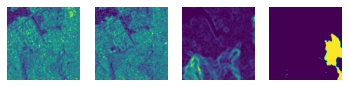

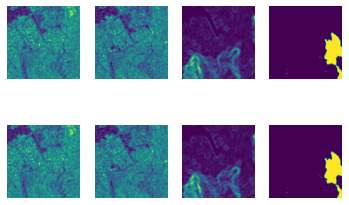

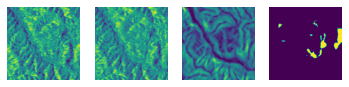

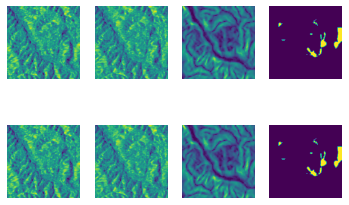

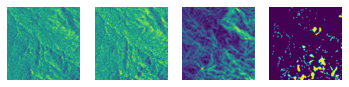

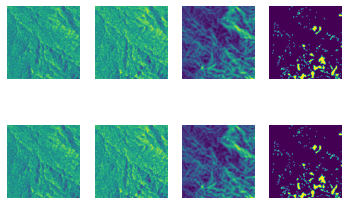

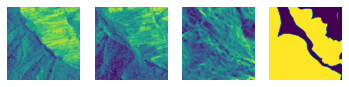

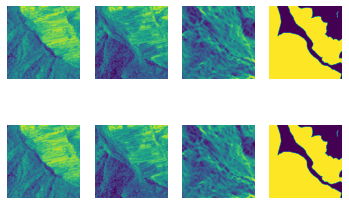

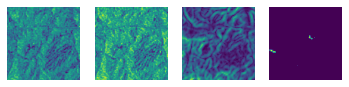

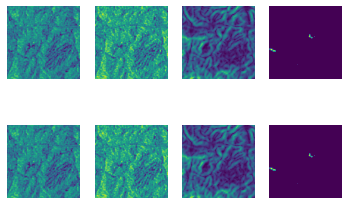

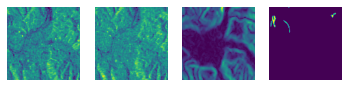

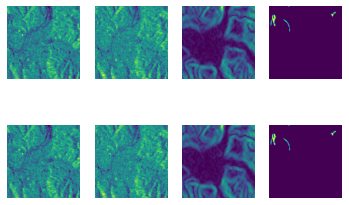

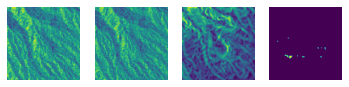

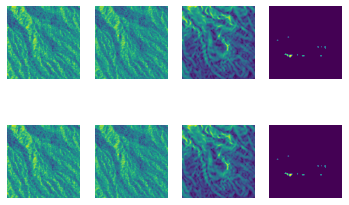

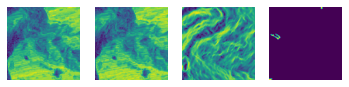

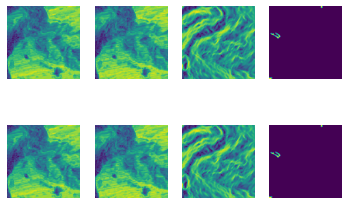

In [ ]:
#Visualize the min and max images of 'large ls' images for each region

check_images(path,'hiromax',arr_ls_1[0][0],arr_ls_1[1][0],max_sar=max_sar)
check_images(path,'hokmax',arr_ls_2[0][0],arr_ls_2[1][0],max_sar=max_sar)
check_images(path,'lommax',arr_ls_3[0][0],arr_ls_3[1][0],max_sar=max_sar)
check_images(path,'humax',arr_ls_4[0][0],arr_ls_4[1][0],max_sar=max_sar)


check_images(path,'hiromax',arr_ls_1[0][-1],arr_ls_1[1][-1],max_sar=max_sar)
check_images(path,'hokmax',arr_ls_2[0][-1],arr_ls_2[1][-1],max_sar=max_sar)
check_images(path,'lommax',arr_ls_3[0][-1],arr_ls_3[1][-1],max_sar=max_sar)
check_images(path,'humax',arr_ls_4[0][-1],arr_ls_4[1][-1],max_sar=max_sar)

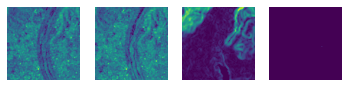

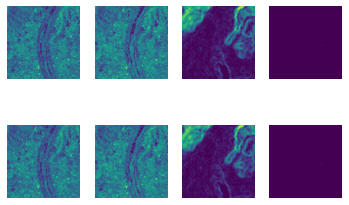

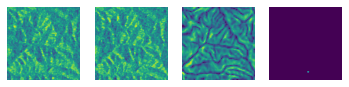

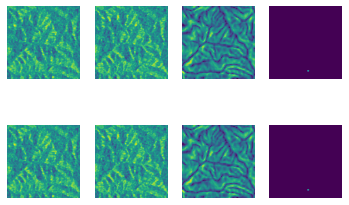

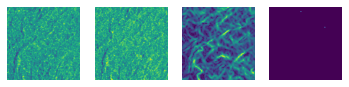

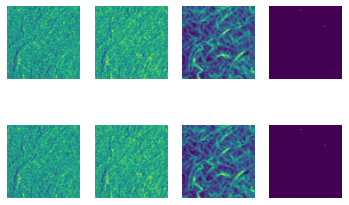

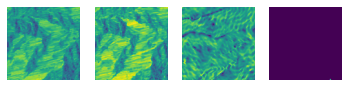

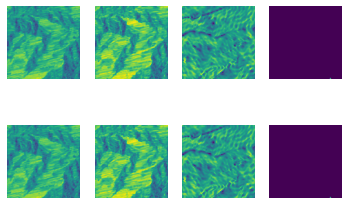

In [ ]:
#Visualize 'small' ls for each region, or smallest for each region

check_images(path,'hiro_all_ls_min',xb1[-1],yb1[-1],max_sar=max_sar)
check_images(path,'hok_all_ls_min',xb2[-1],yb2[-1],max_sar=max_sar)
check_images(path,'lom_all_ls_min',xb3[-1],yb3[-1],max_sar=max_sar)
check_images(path,'hu_all_ls_min',xb4[-1],yb4[-1],max_sar=max_sar)

In [ ]:
print(len(xb1),len(yb1),len(xb2),len(yb2),len(xb3),len(yb3),len(xb4),len(yb4))

356 356 15 15 129 129 31 31


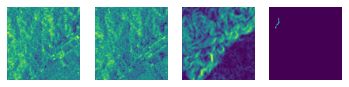

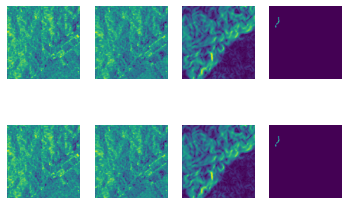

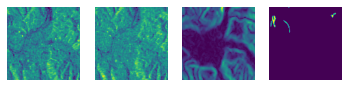

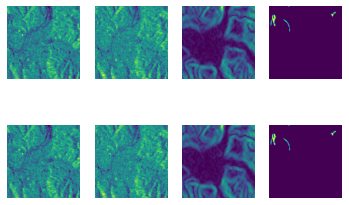

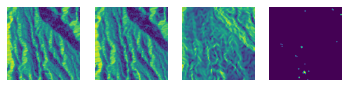

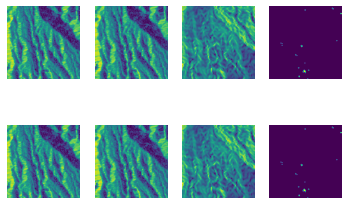

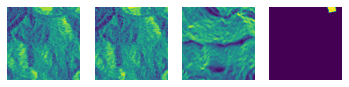

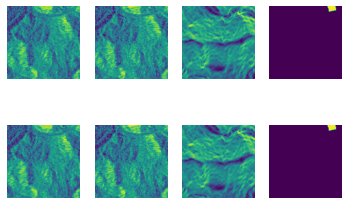

In [ ]:
#Visualize 'small' ls for each region, or smallest for each region

check_images(path,'hiro_all_ls_med',xb1[200],yb1[200],max_sar=max_sar)
check_images(path,'hok_all_ls_med',xb2[8],yb2[8],max_sar=max_sar)
check_images(path,'lom_all_ls_med',xb3[65],yb3[65],max_sar=max_sar)
check_images(path,'hu_all_ls_med',xb4[15],yb4[15],max_sar=max_sar)

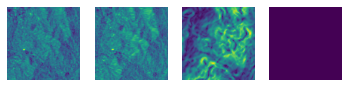

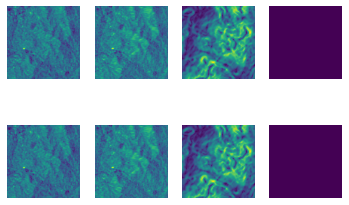

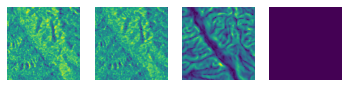

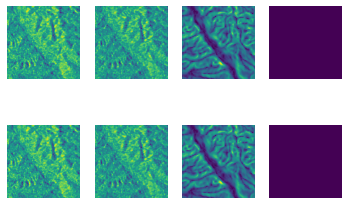

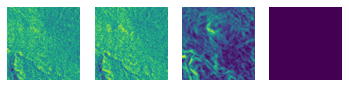

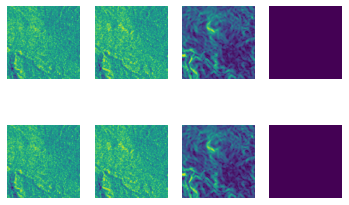

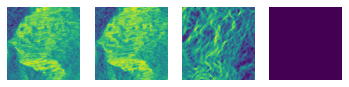

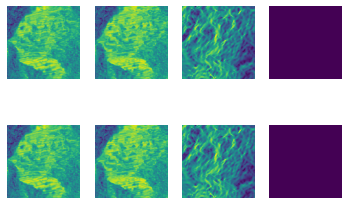

In [ ]:
#Visualize non ls for each region
check_images(path,'hiro_non_ls',xx1[200],yy1[200],max_sar=max_sar)
check_images(path,'hok_non_ls',xx2[8],yy2[8],max_sar=max_sar)
check_images(path,'lom_non_ls',xx3[65],yy3[65],max_sar=max_sar)
check_images(path,'hu_non_ls',xx4[15],yy4[15],max_sar=max_sar)

## Write to tfrecord

In [ ]:
tfrec_path = "/content/drive/MyDrive/Thesis/1409_tfrec_ls/"
tfrec_path_all_ls = tfrec_path + "all_ls/"
tfrec_path_big_ls = tfrec_path + "big_ls/"

# os.makedirs(tfrec_path)
# os.makedirs(tfrec_path_all_ls)
# os.makedirs(tfrec_path_big_ls)


In [ ]:
x,y = mix_regions(arr_ls_1[0][:],arr_ls_2[0][:],arr_ls_3[0][:],
                  arr_ls_4[0][:],arr_ls_1[1][:],arr_ls_2[1][:],arr_ls_3[1][:],arr_ls_4[1][:])
run_write(x,y,tfrec_path_big_ls,'big_ls_asc_',max_sar)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

In [ ]:
x,y = mix_regions(xb1,xb2,xb3,xb4,yb1,yb2,yb3,yb4)
run_write(x,y,tfrec_path_all_ls,'all_ls_asc_',max_sar)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

In [ ]:
x,y = mix_regions(vx1,vx2,vx3,vx4,vy1,vy2,vy3,vy4)
run_write(x,y,tfrec_path_all_ls,'all_ls_val_asc_',max_sar)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

In [ ]:
## Write test ls
x,y = mix_regions(tx1,tx2,tx3,tx4,ty1,ty2,ty3,ty4)
run_write(x,y,tfrec_path_all_ls,'all_ls_test_asc_',max_sar)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

# Des

des max sar is 26 and max dem is 85. The max sar comes from hiro, max dem comes from hu

In [ ]:
max_sar = 26

## Path to tiff files

In [ ]:
#Export from GEE, from Path(s)
tiff_file_path_des = "/content/drive/MyDrive/Thesis/Exportv4dB256/"
tiff_file_path_des_x = tiff_file_path_des + 'X/'
tiff_file_path_des_y = tiff_file_path_des + "Y/"
tiff_file_path_des_y_ls = tiff_file_path_des_y + "LS/"
tiff_file_path_des_y_non_ls = tiff_file_path_des_y + "NonLS/"
tiff_file_path_des_x_ls = tiff_file_path_des_x + "LS/"
tiff_file_path_des_x_non_ls = tiff_file_path_des_x + "NonLS/"

In [ ]:
!ls -la {tiff_file_path_des_x_ls}

total 17
drwx------ 2 root root 4096 Jul  8 10:14 Hiro
drwx------ 2 root root 4096 Jun 17 08:30 Hok
drwx------ 2 root root 4096 Jun 21 12:16 Hu
drwx------ 2 root root 4096 Jun 21 12:17 Lombok
-rw------- 1 root root  151 Jun 17 08:29 readme.gdoc


In [ ]:
!ls -la {tiff_file_path_des_y_non_ls}

total 17
drwx------ 2 root root 4096 Jul  7 17:20 Hiro
drwx------ 2 root root 4096 Jun 17 08:35 Hok
drwx------ 2 root root 4096 Jun 17 08:36 Hu
drwx------ 2 root root 4096 Jun 17 08:36 Lombok
-rw------- 1 root root  151 Jun 17 08:35 Readme.gdoc


## Path to npz files

In [ ]:
thesis_path = "/content/drive/MyDrive/Thesis/Exportv4dB256/Compressed_npz/trainTestDivision/"

# !ls -la {thesis_path}
thesis_path_npz_new = thesis_path + 'new_div_asc/' #also the des are in here
# !ls -la {thesis_path_npz_new}

In [ ]:
path_train1 = thesis_path_npz_new+"Hiro_des_train.npz"
path_train4 = thesis_path_npz_new+"Hu_des_train.npz"
path_train2 = thesis_path_npz_new+"Hok_des_train.npz"
path_train3 = thesis_path_npz_new+"Lom_des_train.npz"

In [ ]:
path_test1 = thesis_path_npz_new+"Hiro_des_test.npz"
path_test4 = thesis_path_npz_new+"Hu_des_test.npz"
path_test2 = thesis_path_npz_new+"Hok_des_test.npz"
path_test3 = thesis_path_npz_new+"Lom_des_test.npz"

In [ ]:
path_val1 = thesis_path_npz_new+"Hiro_des_val.npz"
path_val4 = thesis_path_npz_new+"Hu_des_val.npz"
path_val2 = thesis_path_npz_new+"Hok_des_val.npz"
path_val3 = thesis_path_npz_new+"Lom_des_val.npz"

In [ ]:
#ls train
x1,y1 = open_npz_ls(path_train1)
x2,y2 = open_npz_ls(path_train2)
x3,y3 = open_npz_ls(path_train3)
x4,y4 = open_npz_ls(path_train4)

In [ ]:
#ls test
tx1,ty1 = open_npz_ls(path_test1)
tx2,ty2 = open_npz_ls(path_test2)
tx3,ty3 = open_npz_ls(path_test3)
tx4,ty4 = open_npz_ls(path_test4)

In [ ]:
#ls val
vx1,vy1 = open_npz_ls(path_val1)
# vx2,vy2 = open_npz_ls(path_val2)
vx2,vy2 = [[],[]]
vx3,vy3 = open_npz_ls(path_val3)
vx4,vy4 = open_npz_ls(path_val4)

In [ ]:
#non  ls train
xx1,yy1 = open_npz_non_ls(path_train1)
xx2,yy2 = open_npz_non_ls(path_train2)
xx3,yy3 = open_npz_non_ls(path_train3)
xx4,yy4 = open_npz_non_ls(path_train4)

## Order on ls for big ls

In [ ]:
xb4,yb4= get_ordered_ls_x_y(x4,y4)
xb3,yb3= get_ordered_ls_x_y(x3,y3)
xb2,yb2= get_ordered_ls_x_y(x2,y2)
xb1,yb1= get_ordered_ls_x_y(x1,y1)

In [ ]:
#then need to find corresponding x!
arr_ls_1 = [[],[]]
arr_ls_2 = [[],[]]
arr_ls_3 = [[],[]]
arr_ls_4 = [[],[]]

for i in range(100):
  arr_ls_1[0].append(xb1[i])
  arr_ls_1[1].append(yb1[i])

for i in [100,106,108,109,110,124,18,145,146,148]:
  arr_ls_1[0].append(xb1[i])
  arr_ls_1[1].append(yb1[i])
  

for i in range(9):
  arr_ls_2[0].append(xb2[i])
  arr_ls_2[1].append(yb2[i])

for i in range(63):
  arr_ls_3[0].append(xb3[i])
  arr_ls_3[1].append(yb3[i])

for i in range(20):
  arr_ls_4[0].append(xb4[i])
  arr_ls_4[1].append(yb4[i])

## Visualize images

Check the big ls ones, make some plots of the min and max
Also write to tfrec
Do same for the total ls ones...
Which are actually xb1-4, yb1-4 because these are ordered but not yet big ls. 

In [ ]:
path = "/content/drive/MyDrive/Thesis/src_tar_images/big_ls/des/"
os.makedirs(path)

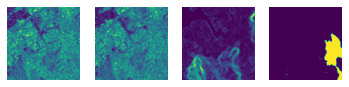

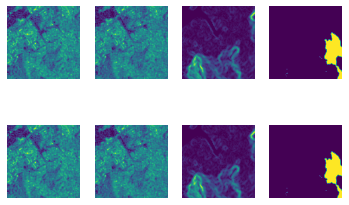

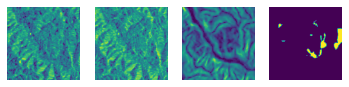

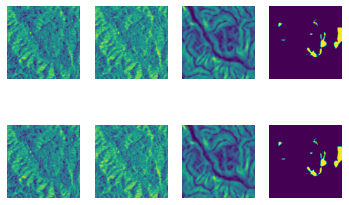

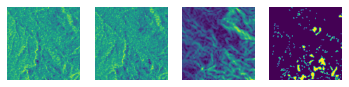

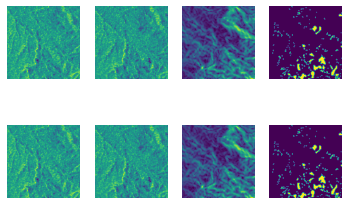

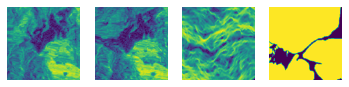

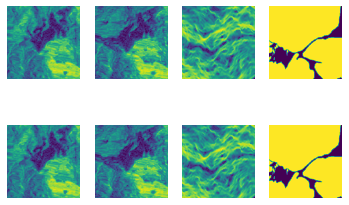

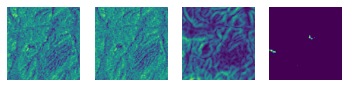

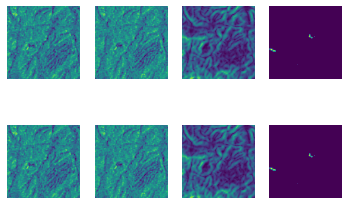

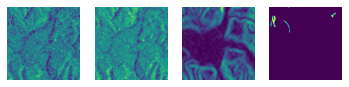

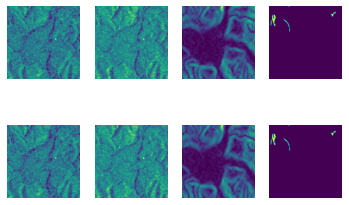

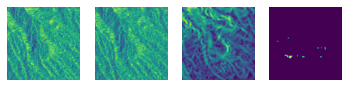

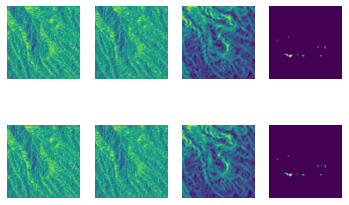

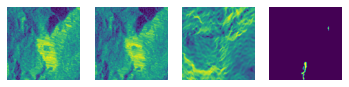

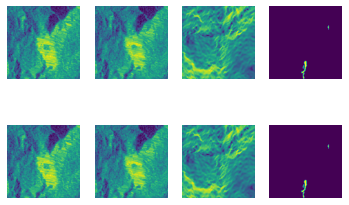

In [ ]:
#Visualize the min and max images of 'large ls' images for each region

check_images(path,'hiromax',arr_ls_1[0][0],arr_ls_1[1][0],max_sar=max_sar)
check_images(path,'hokmax',arr_ls_2[0][0],arr_ls_2[1][0],max_sar=max_sar)
check_images(path,'lommax',arr_ls_3[0][0],arr_ls_3[1][0],max_sar=max_sar)
check_images(path,'humax',arr_ls_4[0][0],arr_ls_4[1][0],max_sar=max_sar)


check_images(path,'hiromax',arr_ls_1[0][-1],arr_ls_1[1][-1],max_sar=max_sar)
check_images(path,'hokmax',arr_ls_2[0][-1],arr_ls_2[1][-1],max_sar=max_sar)
check_images(path,'lommax',arr_ls_3[0][-1],arr_ls_3[1][-1],max_sar=max_sar)
check_images(path,'humax',arr_ls_4[0][-1],arr_ls_4[1][-1],max_sar=max_sar)

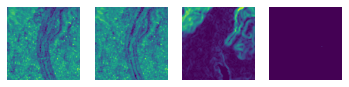

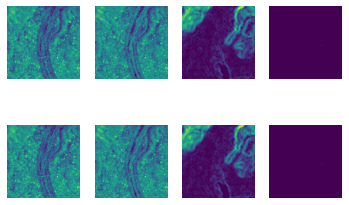

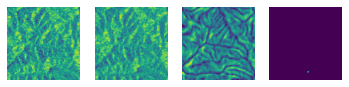

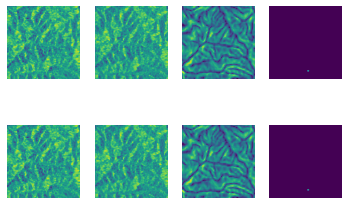

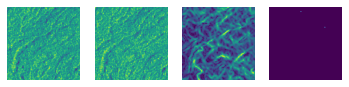

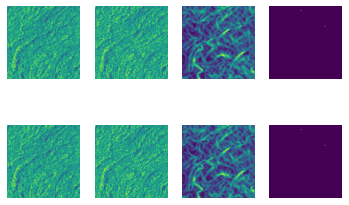

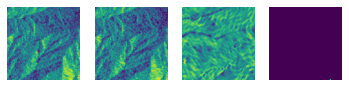

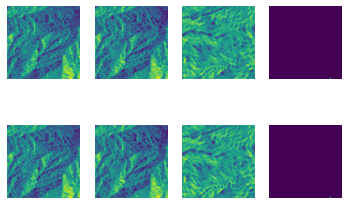

In [ ]:
#Visualize 'small' ls for each region, or smallest for each region

check_images(path,'hiro_all_ls_min',xb1[-1],yb1[-1],max_sar=max_sar)
check_images(path,'hok_all_ls_min',xb2[-1],yb2[-1],max_sar=max_sar)
check_images(path,'lom_all_ls_min',xb3[-1],yb3[-1],max_sar=max_sar)
check_images(path,'hu_all_ls_min',xb4[-1],yb4[-1],max_sar=max_sar)

In [ ]:
print(len(xb1),len(yb1),len(xb2),len(yb2),len(xb3),len(yb3),len(xb4),len(yb4))

356 356 15 15 129 129 30 30


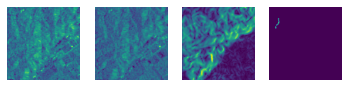

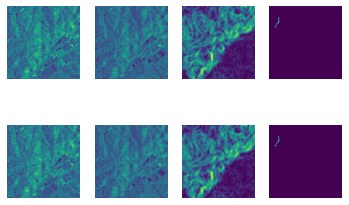

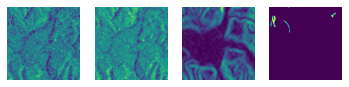

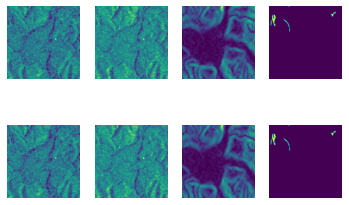

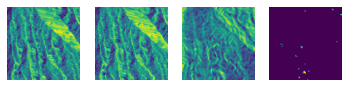

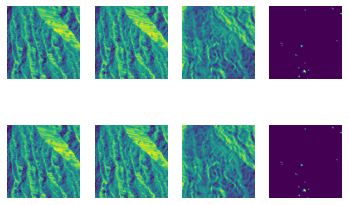

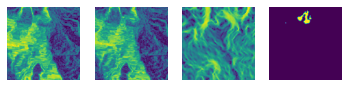

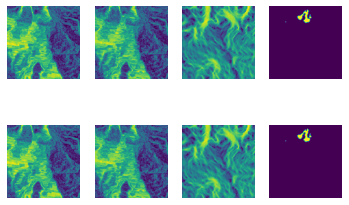

In [ ]:
#Visualize 'small' ls for each region, or smallest for each region

check_images(path,'hiro_all_ls_med',xb1[200],yb1[200],max_sar=max_sar)
check_images(path,'hok_all_ls_med',xb2[8],yb2[8],max_sar=max_sar)
check_images(path,'lom_all_ls_med',xb3[65],yb3[65],max_sar=max_sar)
check_images(path,'hu_all_ls_med',xb4[15],yb4[15],max_sar=max_sar)

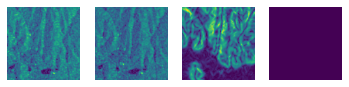

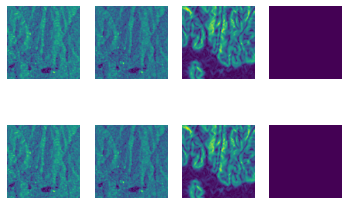

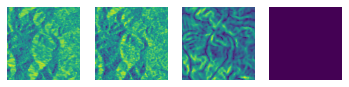

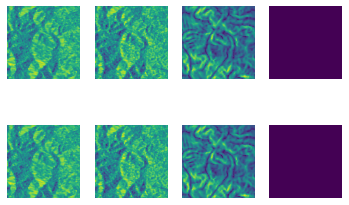

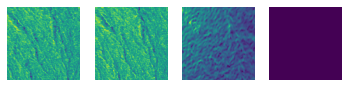

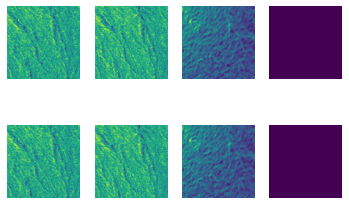

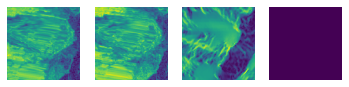

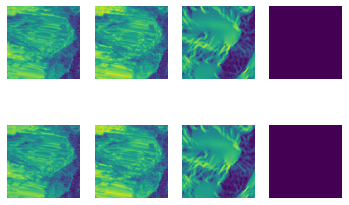

In [ ]:
#Visualize non ls for each region
check_images(path,'hiro_non_ls',xx1[200],yy1[200],max_sar=max_sar)
check_images(path,'hok_non_ls',xx2[8],yy2[8],max_sar=max_sar)
check_images(path,'lom_non_ls',xx3[65],yy3[65],max_sar=max_sar)
check_images(path,'hu_non_ls',xx4[15],yy4[15],max_sar=max_sar)

## Write to tfrecord

In [ ]:
tfrec_path = "/content/drive/MyDrive/Thesis/1409_tfrec_ls/"
tfrec_path_all_ls = tfrec_path + "all_ls/des/"
tfrec_path_big_ls = tfrec_path + "big_ls/des/"

# os.makedirs(tfrec_path)
# os.makedirs(tfrec_path_all_ls)
# os.makedirs(tfrec_path_big_ls)


In [ ]:
x,y = mix_regions(arr_ls_1[0][:],arr_ls_2[0][:],arr_ls_3[0][:],
                  arr_ls_4[0][:],arr_ls_1[1][:],arr_ls_2[1][:],arr_ls_3[1][:],arr_ls_4[1][:])
run_write(x,y,tfrec_path_big_ls,'big_ls_des_',max_sar)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

In [ ]:
x,y = mix_regions(xb1,xb2,xb3,xb4,yb1,yb2,yb3,yb4)
run_write(x,y,tfrec_path_all_ls,'all_ls_des_',max_sar)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

In [ ]:
x,y = mix_regions(vx1,vx2,vx3,vx4,vy1,vy2,vy3,vy4)
run_write(x,y,tfrec_path_all_ls,'all_ls_val_des_',max_sar)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

In [ ]:
x,y = mix_regions(tx1,tx2,tx3,tx4,ty1,ty2,ty3,ty4)
run_write(x,y,tfrec_path_all_ls,'all_ls_test_des_',max_sar)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]